## Introduction and General Idea

Scope of the study: evaluate regeression model by training, validating and testing Linear regression, Random Forest and DNN. 


Material datasets downloaded with Material Project datasets (MPR) API. Datasets used has Silicon as its primary element. Read dataset as pandas framework. Used matplotlib and pandas plotting function to visulalize histogram distribution, features correlation.


Used energy above hull as the parameter of interest (POI). Nine features used to train ML. Applied filters to remove duplicate, undstable, NaN cbm and vbm.


**Importing packages from:**

*DNN --> tensorflow*

*Random Forest & Linear Regression --> sklearn*

*Plotting*

*MPR*

*Other packages*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
import xgboost as xgb

# Linear regression and random forest packages
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# plotting and general packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re
from collections import OrderedDict, defaultdict
from flatten_dict import flatten
import seaborn as sns

# material project datasets
from mp_api.client.mprester import MPRester 
import creds


**Extract Information**

- Define features

- Obtain Data from MPR (Material Project Reader)

    - Filter unstable entries, band gap, formation energy

- Put the data in pandas datafram 

- Prepare pd.DataFrame for ML

- Add volume and magnetization descriptor

In [4]:
field = ["formation_energy_per_atom", "band_gap", "energy_per_atom","total_magnetization",
         "volume","composition","energy_above_hull" ,"nelements",'nsites',"formula_pretty","is_stable","density"
         ,"vbm","cbm"]


apiid = creds.api_key # saved api into cred.py and called to keep the code secured

with MPRester(apiid) as mpr:
    docs = mpr.materials.summary.search(elements=['Si'],
                                        formation_energy=(-20,5),
                                        fields=field,
                                        )
flattened = [{
      k: v
      for k, v in flatten(doc.dict(), reducer="dot").items()
      if k != "fields_not_requested"
  } for doc in docs]

df = pd.DataFrame.from_records(flattened)
print('before removing cbm and vbm NaN size=',df.shape)
df.drop_duplicates('formula_pretty', keep='first', inplace=True)
df.dropna(subset=["cbm","vbm"],inplace=True) # filter NaN cbm and vbm

#df  = df[(df['formation_energy_per_atom']>-20) & (df['formation_energy_per_atom']<5)]
print('after removing cbm and vbm NaN size=',df.shape)

all_columns_inmpr = df.columns #all features list
df_mp = df.drop(columns=[col for col in df if col not in field])

# compute and add two descriptors 
df_mp['vpa'] = df['volume']/df['nsites']
df_mp['magmom_pa'] = df['total_magnetization'] / df['nsites']

Retrieving SummaryDoc documents:   0%|          | 0/12675 [00:00<?, ?it/s]

before removing cbm and vbm NaN size= (12675, 153)
after removing cbm and vbm NaN size= (6158, 153)


# Preamble

- Explore dataset and statistics

- Visualize features: histograms and correlation

In [3]:
df_mp.head()

,nsites,nelements,formula_pretty,volume,density,energy_per_atom,formation_energy_per_atom,energy_above_hull,is_stable,band_gap,cbm,vbm,total_magnetization,vpa,magmom_pa
74,90,2,SiO2,1437.576563,2.082094,-8.259021,-3.151941,0.120891,False,5.0170,4.5771,-0.4399,0.000013,15.973073,1.444444e-07
78,15,2,SiO4,231.425222,1.982164,-5.563841,-0.520408,1.443291,False,0.1484,-0.0536,-0.2020,0.000000,15.428348,0.000000e+00
99,30,2,SiH2,538.826918,0.927654,-5.194593,0.033403,0.040251,False,4.0154,1.8653,-2.1501,0.000116,17.960897,3.853333e-06
109,9,2,SiH8,118.852494,0.505053,-4.049072,-0.002998,0.001567,False,6.9800,2.4174,-4.5626,0.000000,13.205833,0.000000e+00
117,8,2,SiBr3,289.982058,3.067005,-3.762081,-1.178042,0.004103,False,3.8434,2.4081,-1.4353,0.000000,36.247757,0.000000e+00


In [4]:
df_mp.describe()

,nsites,nelements,volume,density,energy_per_atom,formation_energy_per_atom,energy_above_hull,band_gap,cbm,vbm,total_magnetization,vpa,magmom_pa
count,6159.000000,6159.000000,6159.000000,6159.000000,6159.000000,6159.000000,6159.000000,6159.000000,6159.000000,6159.000000,6.159000e+03,6159.000000,6.159000e+03
mean,93.609190,4.809385,1315.122073,3.591272,-7.738986,-2.377832,0.099485,2.319584,4.540153,2.222634,3.445795e+00,15.445912,8.144947e-02
std,70.553855,1.164193,995.646076,1.459841,2.695722,0.939872,0.263852,1.495490,2.027625,2.107266,1.122390e+01,16.538599,2.440671e-01
min,2.000000,2.000000,31.428012,0.126373,-53.946229,-3.930646,0.000000,0.000000,-4.113300,-5.066500,0.000000e+00,7.105964,0.000000e+00
25%,36.000000,4.000000,506.631399,2.881003,-7.960274,-2.942708,0.012286,1.131400,3.286200,1.080350,0.000000e+00,12.450577,0.000000e+00
50%,80.000000,5.000000,1087.904383,3.259803,-7.465475,-2.663692,0.054629,2.393600,4.486900,1.773200,6.000000e-07,13.653298,1.770833e-08
75%,120.000000,6.000000,1650.397413,3.875049,-6.875147,-2.257882,0.104634,3.335900,5.650650,2.884450,9.682600e-03,14.982813,2.166833e-04
max,444.000000,9.000000,8187.141994,15.205081,-1.132664,3.956907,4.523367,8.084400,12.046200,10.984800,1.779904e+02,619.939742,3.826380e+00


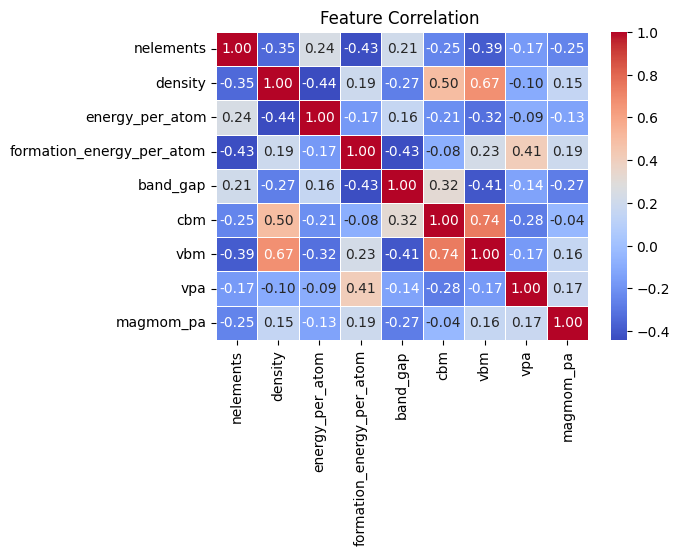

In [5]:
excluded = ['energy_above_hull','volume','nsites','is_stable','formula_pretty','total_magnetization']
included = [c for c in df_mp.columns if c not in excluded]
df_corr = df_mp[included]

plt.figure(figsize=(6, 4))
sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation ")
plt.show()

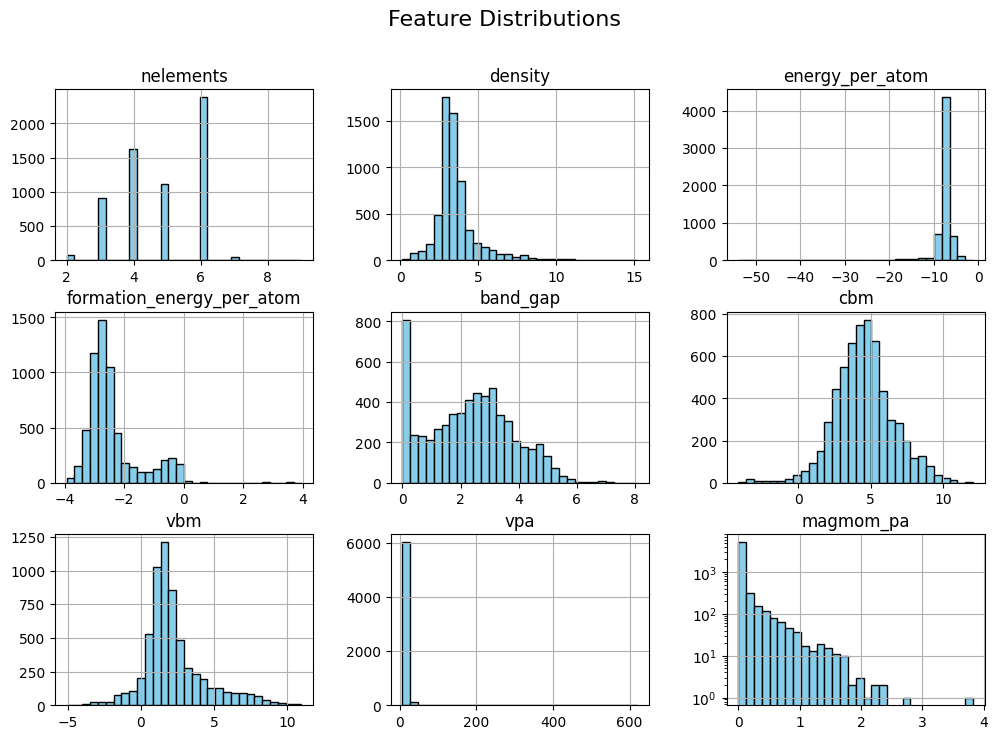

In [6]:
df_corr.hist(figsize=(12, 8), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.yscale('log')
plt.show()

# Linear Regression

Fit Linear Regression model:

- Define target and features

- Fit Linear Regression model

- Plot results

- Cross validate results

In [7]:
y = df_mp['energy_above_hull'].values
excluded = ['energy_above_hull','volume','nsites','is_stable','formula_pretty','total_magnetization']
included = [c for c in df_mp.columns if c not in excluded]
X = df_mp[included].values

#print("Random Forest features are: {}".format(X))

In [8]:
lr = LinearRegression()

lr.fit(X, y)

# get fit statistics
print('R2 = ' + str(round(lr.score(X, y), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=lr.predict(X))))

R2 = 0.573
RMSE = 0.172


Text(0.5, 1.0, 'Linear Regression Model: true vs predict')

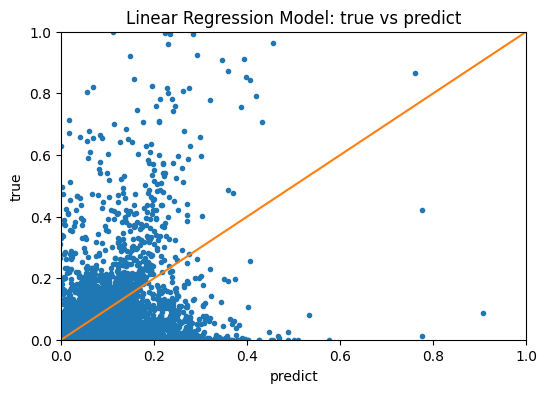

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(lr.predict(X),y,'.')
plt.plot([0,1],[0,1])
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('predict')
plt.ylabel('true')
plt.title('Linear Regression Model: true vs predict')

In [10]:
from sklearn.model_selection import KFold, cross_val_score

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# compute cross validation scores for random forest model
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error',
                         cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean RMSE: 0.172


# Random Forest Regression

Fit Random Forest regression model:

- Define target and features

- Fit random forest model

- Plot the results

- Cross validate results

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=1)

rf.fit(X, y)
print('R2 = ' + str(round(rf.score(X, y), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y, y_pred=rf.predict(X))))

R2 = 0.979
RMSE = 0.038


Text(0.5, 1.0, 'Random Forest Regressor')

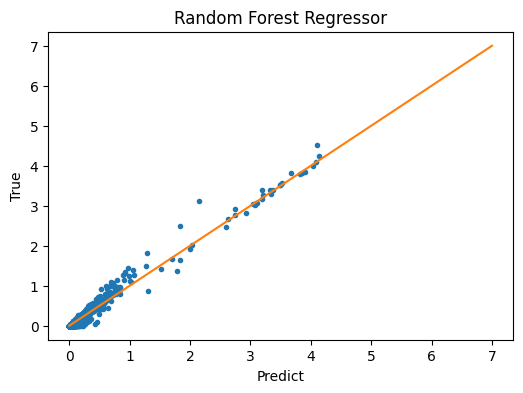

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(rf.predict(X), y,'.')
plt.plot([0,7],[0,7])
plt.xlabel('Predict')
plt.ylabel('True')
plt.title("Random Forest Regressor")

In [13]:
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)

rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean RMSE: 0.096


Text(0.5, 1.0, 'Random Forest Feature importance')

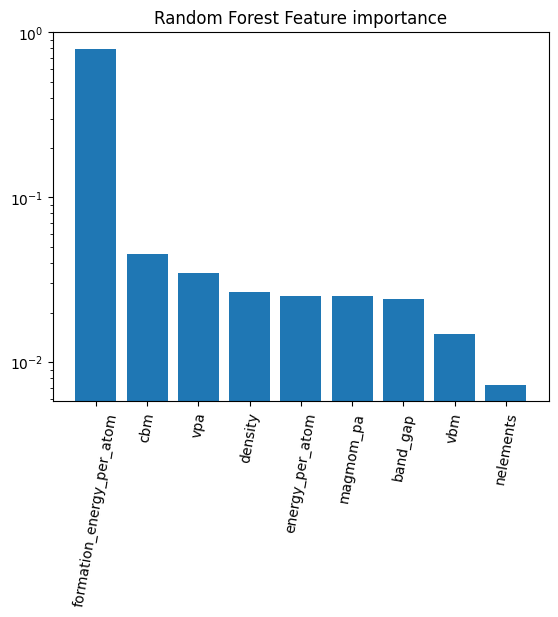

In [14]:
importances = rf.feature_importances_
included = np.asarray(included)
indices = np.argsort(importances)[::-1]

plt.bar(included[indices],height=importances[indices])
plt.tick_params(axis='x', rotation=80)
plt.yscale('log')
plt.title('Random Forest Feature importance')

# DNN:

- Used same dataset features to train, validate and test DNN; used 70% to train, and 15% each to validate and test

- Used 14 dense layers with 1024 neurons (units)

- Activation function: ReLU (rectified linear units)

- Dropout 30% of neuorons to prevent overfitting

- Batch normalization (layer that normalizes input batch to its mean and std) for each dense layer

- early stopping applied to avoid overfitting

- Adam optimizer used with learning rate = 0.0003 (to avoid overfitting), loss function "mae"

In [15]:
y = df_mp['energy_above_hull'].values
excluded = ['energy_above_hull','volume','nsites','is_stable','formula_pretty','total_magnetization']
included = [c for c in df_mp.columns if c not in excluded]
X = df_mp[included].values


from sklearn.model_selection import train_test_split
X_train, X_temp,y_train, y_temp = train_test_split(X,y, test_size=0.3, random_state=1234567)
X_val,   X_test,y_val,   y_test = train_test_split(X_temp,y_temp,test_size=0.5, random_state=1234567)

#X_train.shape, X_valid.shape, X.shape

In [29]:
neurons = 512
# Define model
dnn_model = Sequential()

# Input layer
dnn_model.add(layers.Dense(neurons, activation='relu', input_shape=[X.shape[1]]))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.BatchNormalization())

# Hidden layers (using a loop)
for _ in range(18):  # 18 hidden layers
    dnn_model.add(layers.Dense(neurons, activation='relu'))
    dnn_model.add(layers.Dropout(0.3))
    dnn_model.add(layers.BatchNormalization())

# Output layer
dnn_model.add(layers.Dense(1))

# Define optimizer with learning rate
adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.0003)

#Compile the model
dnn_model.compile(
    optimizer=adam,
    loss='mae',
)
print(dnn_model.summary())

early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True
)

epochs = 40
batch = 256

history_dnn = dnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch,
    epochs=epochs,
    callbacks=[early_stopping]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 512)               5120      
                                                                 
 dropout_55 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_55 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_59 (Dense)            (None, 512)               262656    
                                                                 
 dropout_56 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_56 (Bat  (None, 512)              2048      
 chNormalization)                                     

2025-04-28 08:29:55.933365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.9014

2025-04-28 08:30:02.133848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 9s 241ms/step - loss: 0.9014 - val_loss: 0.3269
Epoch 2/40
17/17 [==============================] - 1s 53ms/step - loss: 0.7160 - val_loss: 0.0903
Epoch 3/40
17/17 [==============================] - 1s 51ms/step - loss: 0.6509 - val_loss: 0.0827
Epoch 4/40
17/17 [==============================] - 1s 42ms/step - loss: 0.6216 - val_loss: 0.0879
Epoch 5/40
17/17 [==============================] - 1s 51ms/step - loss: 0.6002 - val_loss: 0.0918
Epoch 6/40
17/17 [==============================] - 1s 42ms/step - loss: 0.5811 - val_loss: 0.0844
Epoch 7/40
17/17 [==============================] - 1s 50ms/step - loss: 0.5547 - val_loss: 0.0725
Epoch 8/40
17/17 [==============================] - 1s 42ms/step - loss: 0.5516 - val_loss: 0.0732
Epoch 9/40
17/17 [==============================] - 1s 41ms/step - loss: 0.5350 - val_loss: 0.0763
Epoch 10/40
17/17 [==============================] - 1s 41ms/step - loss: 0.5098 - val_loss: 0.0767
Epoch 11/40
17/17 [

Text(0.5, 1.0, 'DNN Loss vs epochs')

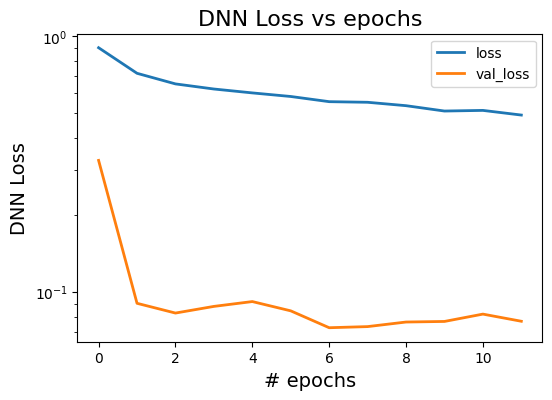

In [30]:
plt.figure(figsize=(6, 4))
history_dfdnn = pd.DataFrame(history_dnn.history)
history_dfdnn['loss'][0:].plot()
history_dfdnn['val_loss'][0:].plot()
plt.legend(['loss','val_loss'])
plt.yscale('log')
plt.xlabel('# epochs')
plt.ylabel('DNN Loss')
plt.title('DNN Loss vs epochs')

29/29 [==============================] - 0s 12ms/step - loss: 0.0801
test loss: 0.0801127701997757


2025-04-28 08:24:57.693745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 10ms/step


Text(0.5, 1.0, 'DNN energy above hull: true vs prediction')

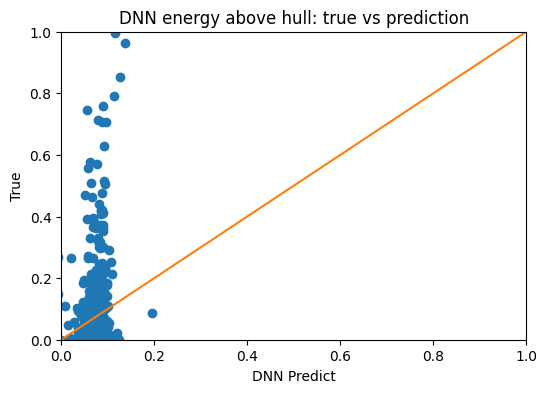

In [18]:
test_loss = dnn_model.evaluate(X_test, y_test)
print(f'test loss: {test_loss}')

ydnn_pred = dnn_model.predict(X_test)
plt.figure(figsize=(6, 4))
plt.plot(ydnn_pred,y_test,'o')
plt.plot([0,7],[0,7])
plt.xlabel("DNN Predict")
plt.ylabel("True")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("DNN energy above hull: true vs prediction")

# XGBoost before DNN

Used extreme gradiant boosting to remove features with low importance

Same DNN architecture and hyperparameters used as DNN training

In [19]:
# Train XGBoost model
xgbreg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model = xgbreg.fit(X_train, y_train)

# Get feature importance
important_features = xgb_model.feature_importances_
selected_features = X_train[:, important_features > 0.01]  # Filtering based on importance

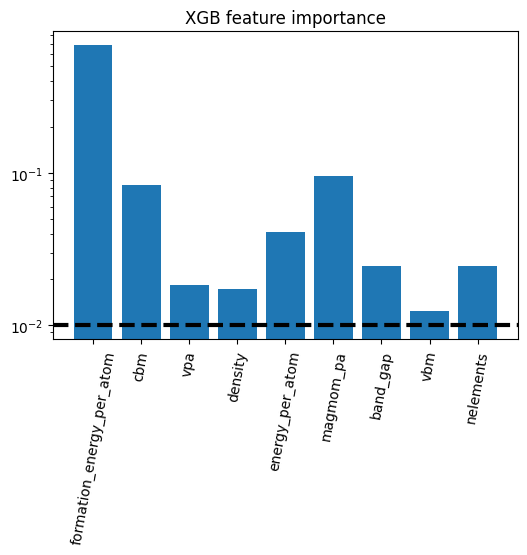

In [20]:
included = np.asarray(included)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(6, 4))
plt.bar(included[indices],height=important_features[indices])
plt.tick_params(axis='x', rotation=80)
plt.yscale('log')
plt.title('XGB feature importance')
plt.axhline(y=0.01,color='black',linewidth=3,linestyle='dashed')

(0.0, 1.0)

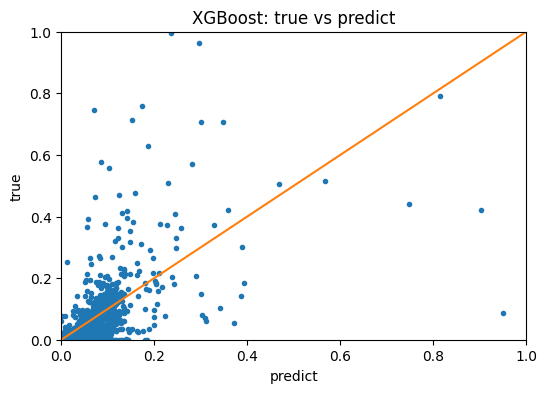

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(xgb_model.predict(X_test),y_test,'.')
plt.title('XGBoost: true vs predict')
plt.xlabel('predict')
plt.ylabel('true')
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [28]:
# Define model
dnnxgb_model = Sequential()
neurons = 512

# Input layer
dnnxgb_model.add(layers.Dense(neurons, activation='relu', input_shape=[X.shape[1]]))
dnnxgb_model.add(layers.Dropout(0.3))
dnnxgb_model.add(layers.BatchNormalization())

# Hidden layers (using a loop)
for _ in range(18):  # 18 hidden layers
    dnnxgb_model.add(layers.Dense(neurons, activation='relu'))
    dnnxgb_model.add(layers.Dropout(0.3))
    dnnxgb_model.add(layers.BatchNormalization())

# Output layer
dnnxgb_model.add(layers.Dense(1))

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True
)

epochs = 40
batch = 256

# Compile & train
dnnxgb_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0003), loss="mse")
history_xgbdnn = dnnxgb_model.fit(
    selected_features, y_train, 
    validation_data=(X_val,y_val),
    epochs=epochs, 
    batch_size=batch,
    callbacks=[early_stopping]
    )

Epoch 1/40


2025-04-28 08:27:15.217527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.4318

2025-04-28 08:27:20.877882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 8s 203ms/step - loss: 1.4318 - val_loss: 0.1320
Epoch 2/40
17/17 [==============================] - 1s 51ms/step - loss: 0.8727 - val_loss: 0.0817
Epoch 3/40
17/17 [==============================] - 1s 44ms/step - loss: 0.7199 - val_loss: 0.0280
Epoch 4/40
17/17 [==============================] - 1s 41ms/step - loss: 0.7027 - val_loss: 0.0284
Epoch 5/40
17/17 [==============================] - 1s 41ms/step - loss: 0.6572 - val_loss: 0.0319
Epoch 6/40
17/17 [==============================] - 1s 46ms/step - loss: 0.5918 - val_loss: 0.0229
Epoch 7/40
17/17 [==============================] - 1s 44ms/step - loss: 0.5843 - val_loss: 0.0287
Epoch 8/40
17/17 [==============================] - 1s 48ms/step - loss: 0.5361 - val_loss: 0.0243
Epoch 9/40
17/17 [==============================] - 1s 45ms/step - loss: 0.5493 - val_loss: 0.0236
Epoch 10/40
17/17 [==============================] - 1s 44ms/step - loss: 0.5196 - val_loss: 0.0211
Epoch 11/40
17/17 [

In [22]:
# Define DNN model
neurons = 512
dnnxgb_model = Sequential([
    layers.Dense(neurons, activation='relu', input_shape=[X.shape[1]]), layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(neurons, activation='relu'),layers.Dropout(0.3),layers.BatchNormalization(),
    layers.Dense(1),
])

early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True
)

epochs = 40
batch = 256

# Compile & train
dnnxgb_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0003), loss="mse")
history_xgbdnn = dnnxgb_model.fit(
    selected_features, y_train, 
    validation_data=(X_val,y_val),
    epochs=epochs, 
    batch_size=batch,
    callbacks=[early_stopping]
    )

Epoch 1/40


2025-04-28 08:25:00.507591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.2781

2025-04-28 08:25:05.626649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 7s 179ms/step - loss: 1.2781 - val_loss: 0.1367
Epoch 2/40
17/17 [==============================] - 1s 46ms/step - loss: 0.8649 - val_loss: 0.0494
Epoch 3/40
17/17 [==============================] - 1s 43ms/step - loss: 0.7295 - val_loss: 0.0326
Epoch 4/40
17/17 [==============================] - 1s 46ms/step - loss: 0.7168 - val_loss: 0.0270
Epoch 5/40
17/17 [==============================] - 1s 42ms/step - loss: 0.6451 - val_loss: 0.0262
Epoch 6/40
17/17 [==============================] - 1s 39ms/step - loss: 0.6141 - val_loss: 0.0303
Epoch 7/40
17/17 [==============================] - 1s 47ms/step - loss: 0.5948 - val_loss: 0.0317
Epoch 8/40
17/17 [==============================] - 1s 47ms/step - loss: 0.5596 - val_loss: 0.0244
Epoch 9/40
17/17 [==============================] - 1s 39ms/step - loss: 0.5811 - val_loss: 0.0270
Epoch 10/40
17/17 [==============================] - 1s 78ms/step - loss: 0.4997 - val_loss: 0.0322
Epoch 11/40
17/17 [

Text(0.5, 1.0, 'DNN after XGBoost loss and val_loss function')

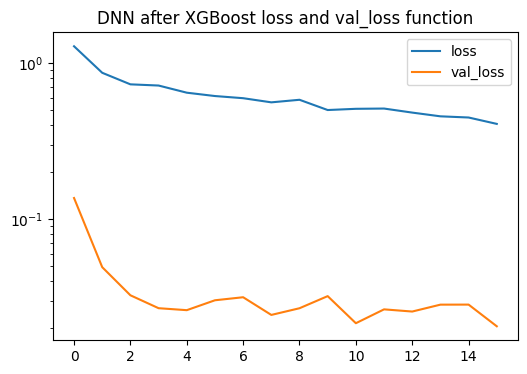

In [23]:
plt.figure(figsize=(6, 4))
history_dnnxgb = pd.DataFrame(history_xgbdnn.history)
history_dnnxgb['loss'][0:].plot()
history_dnnxgb['val_loss'][0:].plot()
plt.legend(['loss','val_loss'])
plt.yscale('log')
plt.title('DNN after XGBoost loss and val_loss function')

29/29 [==============================] - 0s 10ms/step - loss: 0.0423
test loss: 0.042292505502700806


2025-04-28 08:25:18.672429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 9ms/step


(0.0, 1.0)

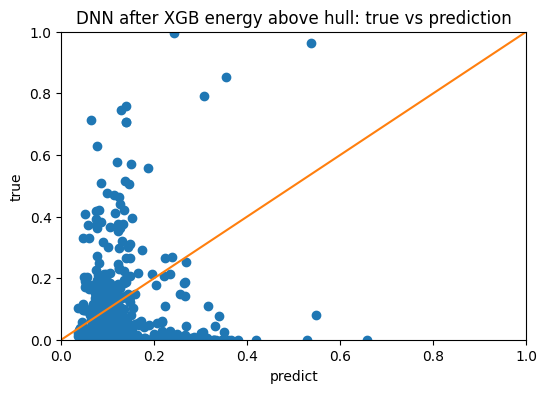

In [24]:
test_loss = dnnxgb_model.evaluate(X_test, y_test)
print(f'test loss: {test_loss}')
plt.figure(figsize=(6, 4))
plt.plot(dnnxgb_model.predict(X_test),y_test,'o')
plt.plot([0,2],[0,2])
plt.xlabel("predict")
plt.ylabel("true")
plt.title("DNN after XGB energy above hull: true vs prediction")
plt.ylim(0,1)
plt.xlim(0,1)

# Some plotting:

ML Algo Comparison:

- Linear regression,

- Random Forest, 

- XGB,

- DNN,

- XGB + DNN

Distributions: Loss (validation) function, energy above hull --> ML predictions & True values; Test datasets used for evaluation

In [31]:
plt.rc('figure', figsize=(6,4))
plt.rc('axes', labelsize=14, titlesize=16)
plt.rc('lines', linewidth=2, markersize=8)
plt.rc('grid', linestyle='--', linewidth=0.5)


2025-04-28 08:30:51.861657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 9ms/step


2025-04-28 08:30:52.883773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 9ms/step


Text(0.5, 1.0, 'Energy above hull distribution: ML comparison')

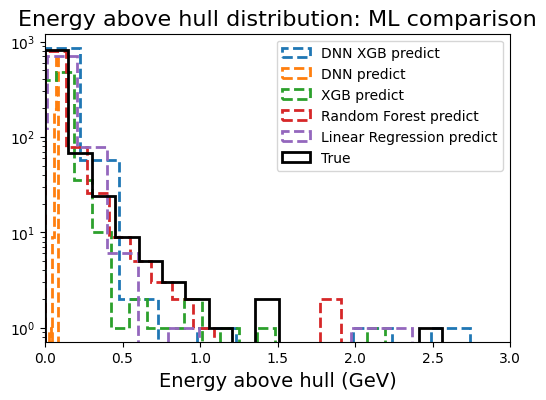

In [32]:
plt.hist(dnnxgb_model.predict(X_test),bins=30,histtype='step',linewidth=2,label='DNN XGB predict', linestyle='dashed')
plt.hist(dnn_model.predict(X_test),bins=30,histtype='step',linewidth=2,label='DNN predict', linestyle='dashed')
plt.hist(xgb_model.predict(X_test),bins=30,histtype='step',linewidth=2,label='XGB predict', linestyle='dashed')
plt.hist(rf.predict(X_test),bins=30,histtype='step',linewidth=2,label='Random Forest predict', linestyle='dashed')
plt.hist(lr.predict(X_test),bins=30,histtype='step',linewidth=2,label='Linear Regression predict', linestyle='dashed')
plt.hist(y_test,bins=30,histtype='step',linewidth=2,label='True',color='black')
plt.legend()
plt.yscale('log')
plt.xlim(0,3)
plt.xlabel('Energy above hull (GeV)')
plt.title('Energy above hull distribution: ML comparison')

Text(0, 0.5, 'loss (val_loss)')

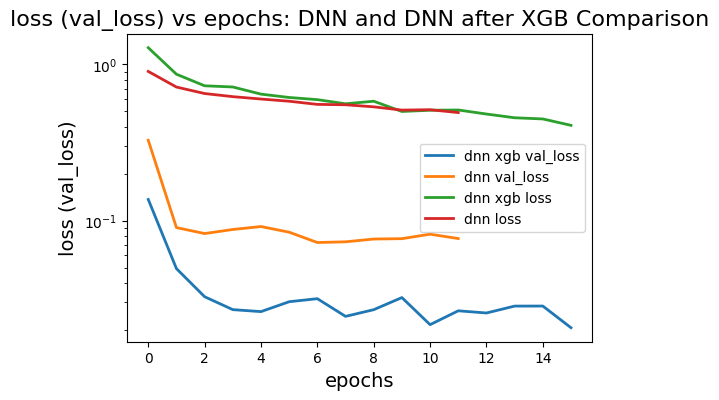

In [ ]:
history_dnnxgb['val_loss'][0:].plot()
history_dfdnn['val_loss'][0:].plot()
history_dnnxgb['loss'][0:].plot()
history_dfdnn['loss'][0:].plot()
plt.legend(['dnn xgb val_loss','dnn val_loss','dnn xgb loss','dnn loss'])
plt.yscale('log')
plt.title('loss (val_loss) vs epochs: DNN and DNN after XGB Comparison')
plt.xlabel('epochs')
plt.ylabel('loss (val_loss)')